In [1]:
import matplotlib
preamble = [
    r'\usepackage{fontspec}',
    r'\setmainfont{Linux Libertine O}',
]
fontsize = 17
ticklen = 5
params = {
    'font.size': fontsize,
    'axes.titlesize': fontsize,
    'xtick.labelsize': fontsize,
    'ytick.labelsize': fontsize,
    'axes.labelsize': fontsize,
    'legend.fontsize': fontsize,
    'text.usetex': True,
    'pgf.rcfonts': False,
    'pgf.texsystem': 'xelatex',
    'pgf.preamble': preamble,
    'xtick.major.size' : ticklen,
    'ytick.major.size' : ticklen,
    'xtick.minor.size' : ticklen/2,
    'ytick.minor.size' : ticklen/2
}
matplotlib.rcParams.update(params)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import decimal

import astropy.constants as const
from astropy.table import Table, Column
from astropy.io import fits
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd

In [4]:
def compute_T0(planet):
    if os.path.exists('../masterfile.ecsv'):
        data = Table.to_pandas(Table.read('../masterfile.ecsv'))
    else:
        print('ERROR: No previously downloaded Exoplanet Archive data - try again when you are connected to the internet.')
        print(FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), '../masterfile.ecsv'))
        exit()

    names = np.array(data['pl_hostname'])+np.array(data['pl_letter'])
    names = np.array([name.replace(' ','').replace('-', '').replace('_','') for name in names])

    nameIndex = np.where(names==planet.replace(' ','').replace('-', '').split('_')[0])[0][0]
    
    if np.isfinite(data['pl_ratdor'][nameIndex]):
        a = data['pl_ratdor'][nameIndex]
        a_err = np.mean([data['pl_ratdorerr1'][nameIndex],
                                -data['pl_ratdorerr2'][nameIndex]])
    else:
        a = data['pl_orbsmax'][nameIndex]*const.au.value/data['st_rad'][nameIndex]/const.R_sun.value
        a_err = np.sqrt(
            (np.mean([data['pl_orbsmaxerr1'][nameIndex], -data['pl_orbsmaxerr2'][nameIndex]])*const.au.value
             /data['st_rad'][nameIndex]/const.R_sun.value)**2
            + (data['pl_orbsmax'][nameIndex]*const.au.value
               /data['st_rad'][nameIndex]**2/const.R_sun.value
               *np.mean([data['st_raderr1'][nameIndex], -data['st_raderr2'][nameIndex]]))**2
        )
    
    Tstar = data['st_teff'][nameIndex]
    Tstar_err = np.mean([data['st_tefferr1'][nameIndex],
                                -data['st_tefferr2'][nameIndex]])

    nIters = 10000
    Tstar = np.random.normal(Tstar, Tstar_err, nIters)
    a = np.random.normal(a, a_err, nIters)
    
    T0 = Tstar*np.sqrt(1/a)
    return np.array([np.median(T0), np.std(T0)])

In [5]:
mainpath   = '/home/taylor/Documents/Research/spitzer/MEGA/'
planets = np.array(['HD189733b', 'WASP-43b', 'Qatar-1b', 'HD209458b', 'CoRoT-2b',
                    'WASP-14b', 'WASP-19b', 'HAT-P-7b', 'WASP-18b', 'KELT-1b',
                    'KELT-16b', 'WASP-103b', 'MASCARA-1b', 'WASP-12b', 'WASP-12b_old',
                    'WASP-33b', 'KELT-9b'])
channels = ['ch2' for planet in planets]
temp_planets = ['_{'.join(planet.split('_'))+'}' if '_' in planet else planet for planet in planets]

fancy_planets = np.array([r'$\rm '+r'$-$\rm '.join(planet.split('-'))+r'$' for planet in temp_planets])
fancy_planets = fancy_planets.astype('<U30')
fancy_planets[fancy_planets=='$\\rm WASP$-$\\rm 12b_{old}$'] = '$\\rm WASP$-$\\rm 12b~(2010)$'
fancy_planets[fancy_planets=='$\\rm WASP$-$\\rm 12b$'] = '$\\rm WASP$-$\\rm 12b~(2013)$'

twoLimits = True

In [6]:
plotModes = ['Poly2', 'Poly3', 'Poly4', 'Poly5', 'BLISS', 'PLDAper1_3x3', 'PLDAper2_3x3', 'PLDAper1_5x5', 'PLDAper2_5x5', 'GP']
fancy_labels = [r'$\rm '+r'\textunderscore '.join(plotMode.split('_'))+r'$' for plotMode in plotModes]

In [7]:
T0s_MEGA = []
As_MEGA = []
Bs_MEGA = []
fps_MEGA = []
offsets_MEGA = []
rps_MEGA = []
tNights_MEGA = []
tDays_MEGA = []
sigFs_MEGA = []
sigF_photons_MEGA = []
sigFs_unBinned_MEGA = []
sigF_photons_unBinned_MEGA = []
modeBICs_MEGA = []
folders_MEGA = []

for i in range(len(plotModes)):
    plotMode = plotModes[i]

    T0s = []
    As = []
    Bs = []
    fps = []
    offsets = []
    rps = []
    tNights = []
    tDays = []
    sigFs = []
    sigF_photons = []
    sigFs_unBinned = []
    sigF_photons_unBinned = []
    modeBICs = []
    folders = []

    for iterNum in range(len(planets)):
        channel = channels[iterNum]
        planet = planets[iterNum]

        # Figure out where files are saved
        phoption = ''
        foldername = ''
        rms = None
        with open(f'{mainpath}{planet}/analysis/{channel}/bestPhOption.txt') as f:
            lines = f.readlines()
        for i in range(len(lines)):
            if phoption=='' and lines[i][0]=='/':
                foldername = mainpath+lines[i][lines[i].find(planet):].strip()+'/'
                phoption = lines[i].split('/')[-1].strip()
                i += 1
                ignoreFrames = np.array(lines[i].strip().split('=')[1].strip().replace(' ','').split(','))
                if np.all(ignoreFrames==['']):
                    ignoreFrames = np.array([]).astype(int)
                else:
                    ignoreFrames = ignoreFrames.astype(int)
                i += 1
                rms = float(lines[i])
            elif phoption!='' and lines[i][0]=='/':
                if float(lines[i+2]) < rms:
                    foldername = mainpath+lines[i][lines[i].find(planet):].strip()+'/'
                    phoption = lines[i].split('/')[-1].strip()
                    i += 1
                    ignoreFrames = np.array(lines[i].split('=')[1].strip().replace(' ','').split(','))
                    if np.all(ignoreFrames==['']):
                        ignoreFrames = np.array([]).astype(int)
                    else:
                        ignoreFrames = ignoreFrames.astype(int)
                    i += 1
                    rms = float(lines[i])
                else:
                    i += 3
        pldFoldernames = np.array(['/'.join(foldername.split('/')[:-2])+'/'+np.array(x)[0].split('/')[-1]+'/' for x in os.walk('/'.join(foldername.split('/')[:-2])+'/') if '4umPLD' in x[0].split('/')[-1] or '3umPLD' in x[0].split('/')[-1]])

        # Figure out what modes were run
        modes = np.sort([x[0].split('/')[-1] for x in os.walk(foldername)][1:])
        for i in range(len(pldFoldernames)):
            modes = np.append(modes, np.sort([x[0].split('/')[-1] for x in os.walk(pldFoldernames[i])][1:]))
        
        # Get rid of PSFX runs
        if planet!='WASP-103b':
            modes = np.array([mode for mode in modes if 'psfx' not in mode.lower()])
        
        # Get rid of non-poet BLISS runs
        if planet not in ['CoRoT-2b', 'WASP-12b', 'WASP-12b_old', 'WASP-103b']:
            modes = np.array([mode for mode in modes if 'bliss' not in mode.lower() or 'poet' in mode.lower()])
        
        # Strip off any extra flags at the end of the mode
        temp_modes = np.array([mode[:mode.lower().find('_v')+3] for mode in modes])

        # If this method was not fully run for this planet+channel, skip it
        if plotMode+'_v1' not in temp_modes:# or plotMode+'_v2' not in temp_modes:
            print(plotMode, 'not run for', planet, channel)
            T0s.append([np.nan, np.nan])
            As.append([np.nan, np.nan, np.nan])
            Bs.append([np.nan, np.nan, np.nan])
            fps.append([np.nan, np.nan, np.nan])
            offsets.append([np.nan, np.nan, np.nan])
            rps.append([np.nan, np.nan, np.nan])
            tNights.append([np.nan, np.nan, np.nan])
            tDays.append([np.nan, np.nan, np.nan])
            sigFs.append([np.nan, np.nan, np.nan])
            sigF_photons.append(np.nan)
            sigFs_unBinned.append([np.nan, np.nan, np.nan])
            sigF_photons_unBinned.append(np.nan)
            modeBICs.append(np.nan)
            folders.append('None')
            continue

        # Pick out only the relevant modes
        modes = modes[np.logical_or(temp_modes==plotMode+'_v1', temp_modes==plotMode+'_v2')]

        BICs = []
        for mode in modes:
            if 'PLD' in plotMode:
                if channel=='ch2':
                    folder='4um'
                else:
                    folder='3um'
                if '3x3' in mode:
                    folder += 'PLD_3x3/'
                else:
                    folder += 'PLD_5x5/'
                savepath   = '/'.join(foldername.split('/')[:-2])+'/'+folder + mode + '/'+ 'ResultMCMC_'+mode+'_Params.npy'
            else:
                savepath   = foldername + mode + '/'+ 'ResultMCMC_'+mode+'_Params.npy'

            if not os.path.exists(savepath):
                BICs.append(np.nan)
            else:
                ResultMCMC = np.load(savepath)
                BICs.append(-2*ResultMCMC['evidenceB'][0])

        if np.all(np.isnan(BICs)):
            T0s.append([np.nan, np.nan])
            As.append([np.nan, np.nan, np.nan])
            Bs.append([np.nan, np.nan, np.nan])
            fps.append([np.nan, np.nan, np.nan])
            offsets.append([np.nan, np.nan, np.nan])
            rps.append([np.nan, np.nan, np.nan])
            tNights.append([np.nan, np.nan, np.nan])
            tDays.append([np.nan, np.nan, np.nan])
            sigFs.append([np.nan, np.nan, np.nan])
            sigF_photons.append(np.nan)
            sigFs_unBinned.append([np.nan, np.nan, np.nan])
            sigF_photons_unBinned.append(np.nan)
            modeBICs.append(np.nan)
            folders.append('None')
            continue
                
        mode = modes[np.nanargmin(BICs)]

        if 'PLD' in plotMode:
            if channel=='ch2':
                folder='4um'
            else:
                folder='3um'
            if '3x3' in mode:
                folder += 'PLD_3x3/'
            else:
                folder += 'PLD_5x5/'
            savepath   = '/'.join(foldername.split('/')[:-2])+'/'+folder + mode + '/'+ 'ResultMCMC_'+mode+'_Params.npy'
        else:
            savepath   = foldername + mode + '/'+ 'ResultMCMC_'+mode+'_Params.npy'

        ResultMCMC = np.load(savepath)
        
        if planet=='WASP-103b':
            ResultMCMC['sigF_photon_ppm'][0] *= (1+0.1234)
        if planet=='WASP-12b':
            ResultMCMC['sigF_photon_ppm'][0] *= (1+0.09976)
        if planet=='WASP-12b_old':
            ResultMCMC['sigF_photon_ppm'][0] *= (1+0.09085)
        if planet=='CoRoT-2b':
            ResultMCMC['sigF_photon_ppm'][0] *= (1+0.2046)
        
        if planet=='KELT-1b':
            T0s.append([6518/np.sqrt(3.60), np.sqrt((50/np.sqrt(3.60))**2+(6518/(3.60)*0.04)**2)])
        else:
            T0s.append(compute_T0(planet))
        fps.append(ResultMCMC['fp']*1e6)
        offsets.append(ResultMCMC['offset'])
        rps.append(ResultMCMC['rp'])
        tNights.append(ResultMCMC['tNight'])
        tDays.append(ResultMCMC['tDay'])
        As.append(ResultMCMC['A'])
        Bs.append(ResultMCMC['B'])
        
        if planet!='WASP-103b':
            sigFs.append(ResultMCMC['sigF']*1e6)
            sigF_photons.append(ResultMCMC['sigF_photon_ppm'][0])
            
            if not 'GP' in mode:
                ndata = ResultMCMC['chi2B']/ResultMCMC['chi2datum']*64
                sigFs_unBinned.append(ResultMCMC['sigF']*1e6*np.sqrt(64)*np.sqrt(ResultMCMC['chi2']/ndata))
                sigF_photons_unBinned.append(ResultMCMC['sigF_photon_ppm'][0]*np.sqrt(64))
            else:
                sigFs_unBinned.append([np.nan, np.nan, np.nan])
                sigF_photons_unBinned.append(np.nan)
        else:
            sigFs.append([np.nan, np.nan, np.nan])
            sigF_photons.append(np.nan)
            sigFs_unBinned.append(ResultMCMC['sigF']*1e6)
            sigF_photons_unBinned.append(ResultMCMC['sigF_photon_ppm'][0])
        
        modeBICs.append(BICs[np.nanargmin(BICs)])
        
        folders.append('/'.join(savepath.split('/')[:-1]))

        print(planet, channel, mode)

    T0s = np.array(T0s).T
    As = np.array(As).T
    Bs = np.array(Bs).T
    fps = np.array(fps).T
    offsets = np.array(offsets).T
    rps = np.array(rps).T
    tNights = np.array(tNights).T
    tDays = np.array(tDays).T
    sigFs = np.array(sigFs).T
    sigF_photons = np.array(sigF_photons)
    sigFs_unBinned = np.array(sigFs_unBinned).T
    sigF_photons_unBinned = np.array(sigF_photons_unBinned)
    modeBICs = np.array(modeBICs)
    folders = np.array(folders)

    T0s_MEGA.append(T0s)
    As_MEGA.append(As)
    Bs_MEGA.append(Bs)
    fps_MEGA.append(fps)
    offsets_MEGA.append(offsets)
    rps_MEGA.append(rps)
    tNights_MEGA.append(tNights)
    tDays_MEGA.append(tDays)
    sigFs_MEGA.append(sigFs)
    sigF_photons_MEGA.append(sigF_photons)
    sigFs_unBinned_MEGA.append(sigFs_unBinned)
    sigF_photons_unBinned_MEGA.append(sigF_photons_unBinned)
    modeBICs_MEGA.append(modeBICs)
    folders_MEGA.append(folders)
    
order = np.argsort(np.nanmedian(np.array(T0s_MEGA)[:,0], axis=0))
    
T0s_MEGA = np.array(T0s_MEGA)[:,:,order]
As_MEGA = np.array(As_MEGA)[:,:,order]
Bs_MEGA = np.array(Bs_MEGA)[:,:,order]
fps_MEGA = np.array(fps_MEGA)[:,:,order]
offsets_MEGA = np.array(offsets_MEGA)[:,:,order]
rps_MEGA = np.array(rps_MEGA)[:,:,order]
tNights_MEGA = np.array(tNights_MEGA)[:,:,order]
tDays_MEGA = np.array(tDays_MEGA)[:,:,order]
sigFs_MEGA = np.array(sigFs_MEGA)[:,:,order]
sigF_photons_MEGA = np.array(sigF_photons_MEGA)[:,order]
sigFs_unBinned_MEGA = np.array(sigFs_unBinned_MEGA)[:,:,order]
sigF_photons_unBinned_MEGA = np.array(sigF_photons_unBinned_MEGA)[:,order]
modeBICs_MEGA = np.array(modeBICs_MEGA)[:,order]
folders_MEGA = np.array(folders_MEGA)[:,order]
planets = np.array(planets)[order]
fancy_planets = np.array(fancy_planets)[order]

HD189733b ch2 Poly2_v2_autoRun
WASP-43b ch2 Poly2_v2_autoRun
Qatar-1b ch2 Poly2_v1_autoRun
HD209458b ch2 Poly2_v2_autoRun
CoRoT-2b ch2 Poly2_v1_autoRun
WASP-14b ch2 Poly2_v1_autoRun
WASP-19b ch2 Poly2_v1_autoRun
HAT-P-7b ch2 Poly2_v2_autoRun
WASP-18b ch2 Poly2_v2_autoRun
KELT-1b ch2 Poly2_v1_autoRun
KELT-16b ch2 Poly2_v1_autoRun
WASP-103b ch2 Poly2_v1_unbinnned_autoRun
MASCARA-1b ch2 Poly2_v2_autoRun
WASP-12b ch2 Poly2_v2_autoRun
WASP-12b_old ch2 Poly2_v2_autoRun
WASP-33b ch2 Poly2_v2_autoRun
KELT-9b ch2 Poly2_v2_autoRun
HD189733b ch2 Poly3_v2_autoRun
WASP-43b ch2 Poly3_v1_autoRun
Qatar-1b ch2 Poly3_v1_autoRun
HD209458b ch2 Poly3_v2_autoRun
CoRoT-2b ch2 Poly3_v1_autoRun
WASP-14b ch2 Poly3_v1_autoRun
WASP-19b ch2 Poly3_v1_autoRun
HAT-P-7b ch2 Poly3_v2_autoRun
WASP-18b ch2 Poly3_v1_autoRun
KELT-1b ch2 Poly3_v1_autoRun
KELT-16b ch2 Poly3_v1_autoRun
WASP-103b ch2 Poly3_v1_unbinnned_autoRun
MASCARA-1b ch2 Poly3_v2_autoRun
WASP-12b ch2 Poly3_v2_autoRun
WASP-12b_old ch2 Poly3_v2_autoRun
WASP-

In [8]:
lit = pd.read_csv('Literature_Values - Bell2020.tsv', delimiter='\t')
lit = lit.iloc[np.where(lit['Planet']!='HD149026b')[0]]

names_lit = np.array(lit['Planet'])

fp_lit = np.array([lit['Fp'][i].split('+') for i in lit.index])
fp_lit = np.array([['nan','nan'] if np.all(fp_lit[i]==['Unpublished']) else fp_lit[i] for i in range(len(fp_lit))]).astype(float)

rp_lit = np.array([lit['Rp'][i].split('+') for i in lit.index])
rp_lit = np.array([['nan','nan'] if np.all(rp_lit[i]==['Unpublished']) else rp_lit[i] for i in range(len(rp_lit))]).astype(float)

amp_lit = np.array([lit['Semi-Amplitude'][i].split('+') for i in lit.index])
amp_lit = np.array([['nan','nan'] if np.all(amp_lit[i]==['Unpublished']) else amp_lit[i] for i in range(len(amp_lit))]).astype(float)

offset_lit = np.array([lit['Offset (E)'][i].split('+') for i in lit.index])
offset_lit = np.array([['nan','nan'] if np.all(offset_lit[i]==['Unpublished']) else offset_lit[i] for i in range(len(offset_lit))]).astype(float)

tday_temp = np.array([lit['Tday'][i].split('+') for i in lit.index])
tday_lit = np.array([['nan','nan'] if np.all(tday_temp[i]==['Unpublished']) else tday_temp[i] for i in range(len(tday_temp))]).astype(float)

tnight_temp = np.array([lit['Tnight'][i].split('+') for i in lit.index])
tnight_lit = np.array([['nan','nan'] if (np.all(tnight_temp[i]==['Unpublished']) or np.all(tnight_temp[i]==['Upper limit'])) else tnight_temp[i] for i in range(len(tnight_temp))]).astype(float)

nBinned_lit = np.array(['nan' if val=='Unpublished' else val for val in lit['N_binned']]).astype(float)

sigF_temp = np.array(['nan' if (lit['Sig_F'][i]=='Unpublished') else lit['Sig_F'][i].strip(' ppm') for i in lit.index])
sigF_lit_unBinned = np.array([float(sigF_temp[i])*np.sqrt(nBinned_lit[i])/sigF_photons_MEGA[0][names_lit[i]==np.array(planets)][0] if ('x' not in sigF_temp[i]) else float(sigF_temp[i][:-1]) for i in range(len(names_lit))])

sigF_temp = np.array(['nan' if (lit['Sig_F'][i]=='Unpublished') else lit['Sig_F'][i].strip(' ppm') for i in lit.index])
sigF_lit = np.array([float(sigF_temp[i])*np.sqrt(nBinned_lit[i]/64.)/sigF_photons_MEGA[0][names_lit[i]==np.array(planets)][0] if ('x' not in sigF_temp[i]) else float(sigF_temp[i][:-1]) for i in range(len(names_lit))])

In [9]:
rp = np.array([rps_MEGA[np.nanargmin(modeBICs_MEGA[:,i]),:,i] if not np.all(np.isnan(modeBICs_MEGA[:,i])) else [np.nan,np.nan] for i in range(len(planets))])
fp = np.array([fps_MEGA[np.nanargmin(modeBICs_MEGA[:,i]),:,i] if not np.all(np.isnan(modeBICs_MEGA[:,i])) else [np.nan,np.nan] for i in range(len(planets))])
amps = fps_MEGA[:,0]*np.sqrt(As_MEGA[:,0]**2+Bs_MEGA[:,0]**2)
amps_err = fps_MEGA[:,:1]*np.sqrt((As_MEGA[:,:1]*As_MEGA[:,1:])**2+(Bs_MEGA[:,:1]*Bs_MEGA[:,1:])**2)/np.sqrt(As_MEGA[:,:1]**2+Bs_MEGA[:,:1]**2)
amp = np.array([amps[np.nanargmin(modeBICs_MEGA[:,i]),i] if not np.all(np.isnan(modeBICs_MEGA[:,i])) else [np.nan,np.nan] for i in range(len(planets))])
amp = np.append(amp[:,np.newaxis], amps_err[np.nanargmin(modeBICs_MEGA, axis=0), :, np.arange(amps_err.shape[2])], axis=1)
offset = np.array([offsets_MEGA[np.nanargmin(modeBICs_MEGA[:,i]),:,i] if not np.all(np.isnan(modeBICs_MEGA[:,i])) else [np.nan,np.nan,np.nan] for i in range(len(planets))])
T0 = np.array([T0s_MEGA[np.nanargmin(modeBICs_MEGA[:,i]),:,i] if not np.all(np.isnan(modeBICs_MEGA[:,i])) else [np.nan,np.nan] for i in range(len(planets))])
Td = np.array([tDays_MEGA[np.nanargmin(modeBICs_MEGA[:,i]),:,i] if not np.all(np.isnan(modeBICs_MEGA[:,i])) else [np.nan,np.nan,np.nan] for i in range(len(planets))])
Tn = np.array([tNights_MEGA[np.nanargmin(modeBICs_MEGA[:,i]),:,i] if not np.all(np.isnan(modeBICs_MEGA[:,i])) else [np.nan,np.nan,np.nan] for i in range(len(planets))])
sigF = np.array([sigFs_MEGA[np.nanargmin(modeBICs_MEGA[:,i]),:,i] if not np.all(np.isnan(modeBICs_MEGA[:,i])) else [np.nan,np.nan,np.nan] for i in range(len(planets))])
usedModes = np.array([plotModes[np.nanargmin(modeBICs_MEGA[:,i])] if not np.all(np.isnan(modeBICs_MEGA[:,i])) else 'None' for i in range(len(planets))])

In [10]:
def roundToSigFigs(x, sigFigs=2):
    nDec = -int(np.floor(np.log10(np.abs(x))))+sigFigs-1
    rounded = np.round(x, nDec)
    if nDec <= 0:
        #remove decimals if this should be an integer
        rounded = int(rounded)
    output = str(rounded)
    if nDec > 1 and np.rint(rounded*10**nDec) % 10 == 0:
        #take care of the trailing zero issue
        output += '0'
    return nDec, output

def roundToDec(x, nDec=2):
    rounded = np.round(x, nDec)
    if nDec <= 0:
        #remove decimals if this should be an integer
        rounded = int(rounded)
    output = str(rounded)
    if nDec > 1 and np.rint(rounded*10**nDec) % 10 == 0:
        #take care of the trailing zero issue
        output += '0'
    return output

In [11]:
def dblErr(val, twoLimits=True):
    if val.size==1:
        if np.isnan(val):
            return '--'
        else:
            return val
    
    if val.size==2:
        val = np.append(val, val[1])
        
    if twoLimits:
        if np.isnan(val[1]):
            nDec1, err1 = 0, ''
        else:
            nDec1, err1 = roundToSigFigs(val[1])
        if np.isnan(val[2]):
            nDec2, err2 = 0, ''
        else:
            nDec2, err2 = roundToSigFigs(val[2])
        nDec = np.max([nDec1, nDec2])
        if np.isnan(val[0]):
            output = '--'
        else:
            val = roundToDec(val[0], nDec)
            output = '$'+val+'^{+'+err1+'}_{-'+err2+'}$'
    else:
        if np.all(np.isnan(val[1:])):
            nDec, err = 0, ''
        else:
            nDec, err = roundToSigFigs(np.nanmean(val[1:]))
        if np.isnan(val[0]):
            output = '--'
        else:
            val = roundToDec(val[0], nDec)
            output = '$'+val+'\pm'+err+'$'

    return output

In [12]:
for i, planet in enumerate(planets):
    if planet in ['KELT-16b', 'MASCARA-1b']:
        print('\\textbf{'+planet+'}', '&', usedModes[i].replace('_', '\\textunderscore'), '&', dblErr(rp[i]), '&', dblErr(fp[i]), '&', dblErr(amp[i]), '&', dblErr(offset[i]), '&', dblErr(T0[i]), '&', dblErr(Td[i]), '&', dblErr(Tn[i]), r'\\')
    else:
        if planet=='WASP-12b_old':
            planet = 'WASP-12b (2010)'
        elif planet=='WASP-12b':
            planet='WASP-12b (2013)'
        print(planet, '&', usedModes[i].replace('_', '\\textunderscore'), '&', dblErr(rp[i]), '&', dblErr(fp[i]), '&', dblErr(amp[i]), '&', dblErr(offset[i]), '&', dblErr(T0[i]), '&', dblErr(Td[i]), '&', dblErr(Tn[i]), r'\\')

HD189733b & Poly5 & $0.15639^{+0.00021}_{-0.00021}$ & $1797^{+24}_{-26}$ & $655^{+34}_{-35}$ & $33.7^{+2.5}_{-2.2}$ & $1699^{+26}_{-26}$ & $1220.8^{+5.8}_{-6.2}$ & $932^{+26}_{-27}$ \\
WASP-43b & BLISS & $0.1584^{+0.0010}_{-0.0012}$ & $3680^{+140}_{-130}$ & $1796^{+61}_{-97}$ & $11.0^{+2.9}_{-2.5}$ & $1996^{+90}_{-90}$ & $1461^{+24}_{-22}$ & $645^{+100}_{-97}$ \\
Qatar-1b & BLISS & $0.1461^{+0.0022}_{-0.0020}$ & $3020^{+240}_{-240}$ & $1460^{+130}_{-220}$ & $-4^{+13}_{-13}$ & $2006^{+38}_{-38}$ & $1538^{+55}_{-53}$ & $800^{+180}_{-170}$ \\
HD209458b & Poly5 & $0.12047^{+0.00039}_{-0.00042}$ & $1376^{+46}_{-40}$ & $485^{+73}_{-64}$ & $43.4^{+5.4}_{-6.1}$ & $2052^{+22}_{-22}$ & $1418^{+23}_{-19}$ & $1009^{+71}_{-81}$ \\
CoRoT-2b & BLISS & $0.1695^{+0.0016}_{-0.0018}$ & $4680^{+200}_{-200}$ & $2620^{+100}_{-110}$ & $-39.5^{+3.2}_{-2.9}$ & $2162^{+49}_{-49}$ & $1748^{+37}_{-40}$ & $887^{+47}_{-47}$ \\
WASP-14b & PLDAper1\textunderscore3x3 & $0.09561^{+0.00049}_{-0.00052}$ & $2327^{+69}_{-6

In [13]:
for i, planet in zip(np.arange(len(names_lit)), names_lit):
    if planet=='WASP-12b_old':
        planet = 'WASP-12b (2010)'
    elif planet=='WASP-12b':
        planet='WASP-12b (2013)'
    print(planet, '&', dblErr(rp_lit[i], False), '&', dblErr(fp_lit[i], False), '&', dblErr(amp_lit[i], False), '&', dblErr(offset_lit[i], False), '&', dblErr(tday_lit[i], False), '&', dblErr(tnight_lit[i], False), '& \\citet{'+lit['Reference'][i].lower().replace('+','')+'}', r'\\')

HD189733b & $0.15580\pm0.00019$ & $1793\pm55$ & $491\pm45$ & $10.1\pm2.8$ & $1192.0\pm9.0$ & $928\pm26$ & \citet{knutson2012} \\
WASP-43b & $0.15890\pm0.00050$ & $3830\pm80$ & $1930\pm60$ & $21.1\pm1.8$ & $1512\pm25$ & -- & \citet{stevenson2017} \\
WASP-43b & -- & $4060\pm100$ & $1630\pm120$ & $12.0\pm3.0$ & $1583\pm28$ & $922\pm81$ & \citet{mendonça2018} \\
WASP-43b & $0.1572\pm0.0010$ & $3870\pm120$ & $1800\pm96$ & $11.3\pm2.1$ & $1539\pm30$ & $730\pm110$ & \citet{morello2019} \\
WASP-43b & -- & $3660\pm120$ & $1613\pm83$ & $20.6\pm2.0$ & $1516\pm29$ & $849\pm74$ & \citet{may2020} \\
Qatar-1b & $0.1450\pm0.0010$ & $3000\pm200$ & $920\pm110$ & $-4.0\pm7.0$ & $1557\pm35$ & $1167\pm71$ & \citet{keating2020} \\
HD209458b & $0.12130\pm0.00030$ & $1317\pm50$ & $545\pm58$ & $40.9\pm6.0$ & $1499\pm15$ & $972\pm44$ & \citet{zellem2014} \\
CoRoT-2b & $0.16970\pm0.00090$ & $4400\pm200$ & $2300\pm150$ & $-23.0\pm4.0$ & $1693\pm17$ & $651\pm47$ & \citet{dang2018} \\
WASP-14b & $0.09421\pm0.00059$

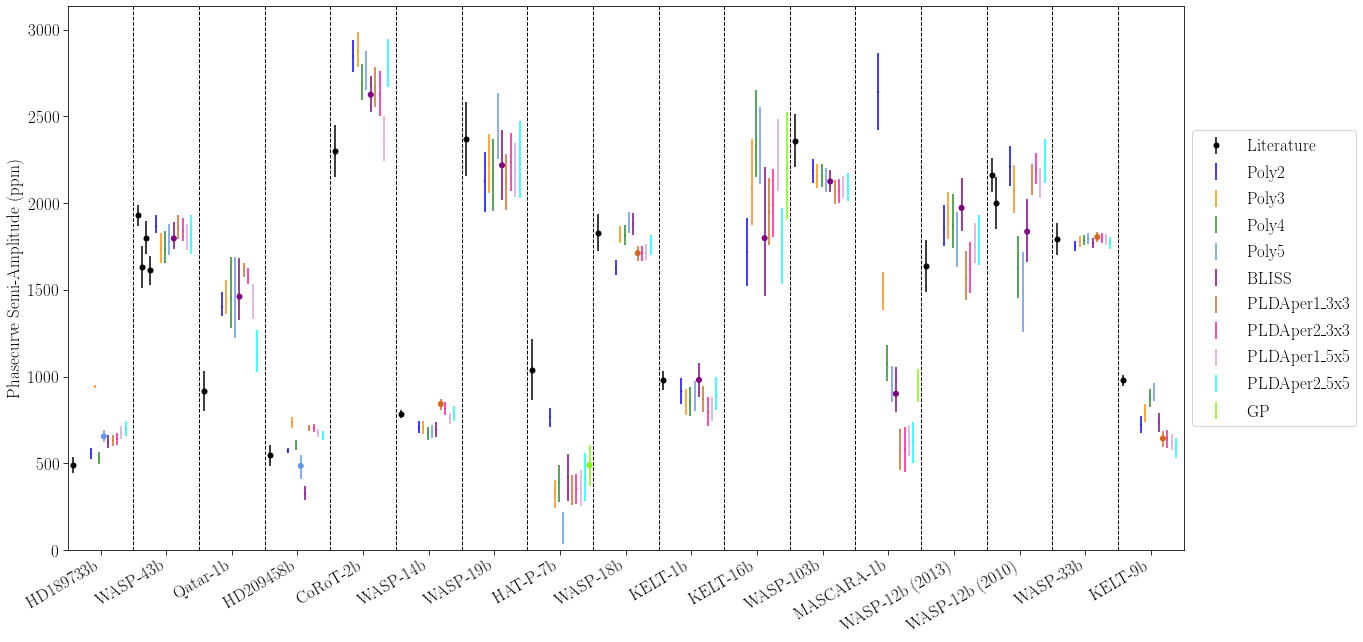

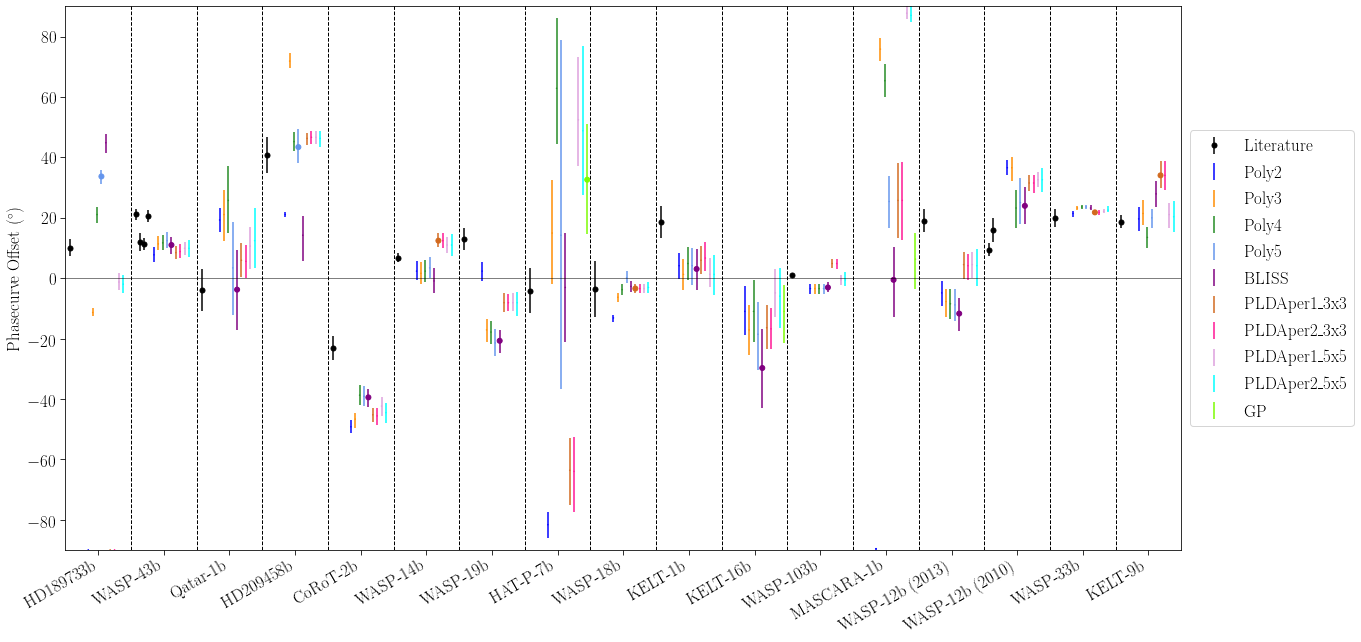

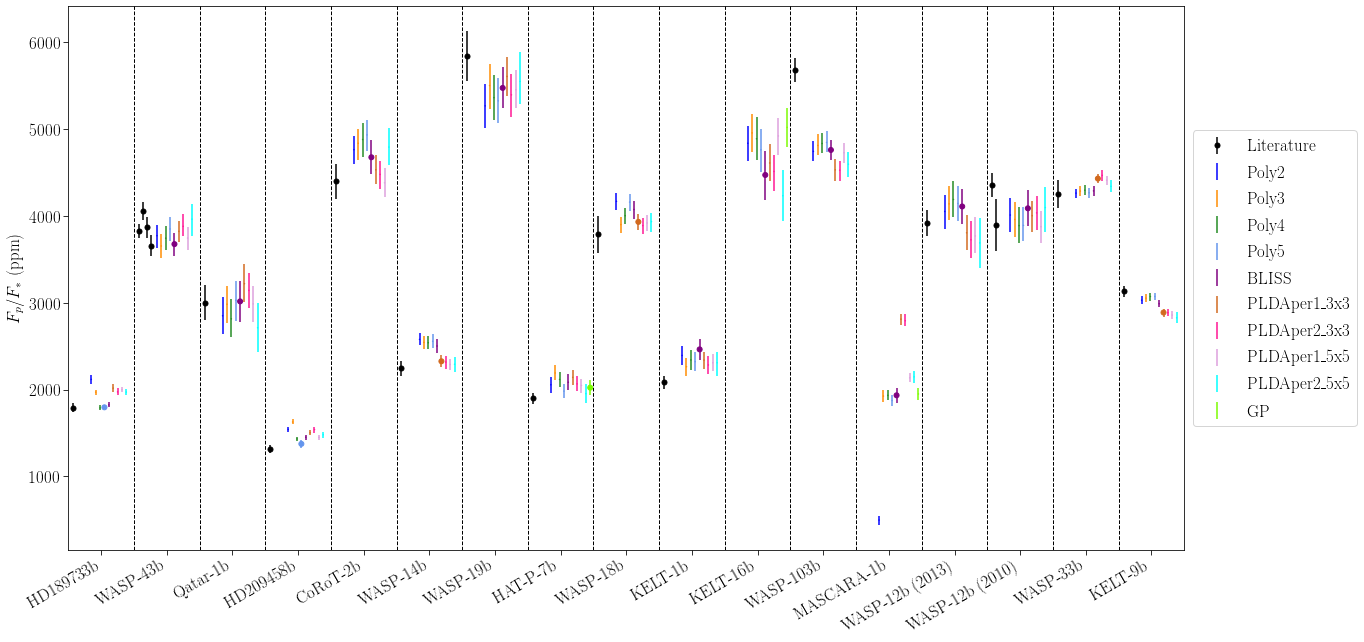

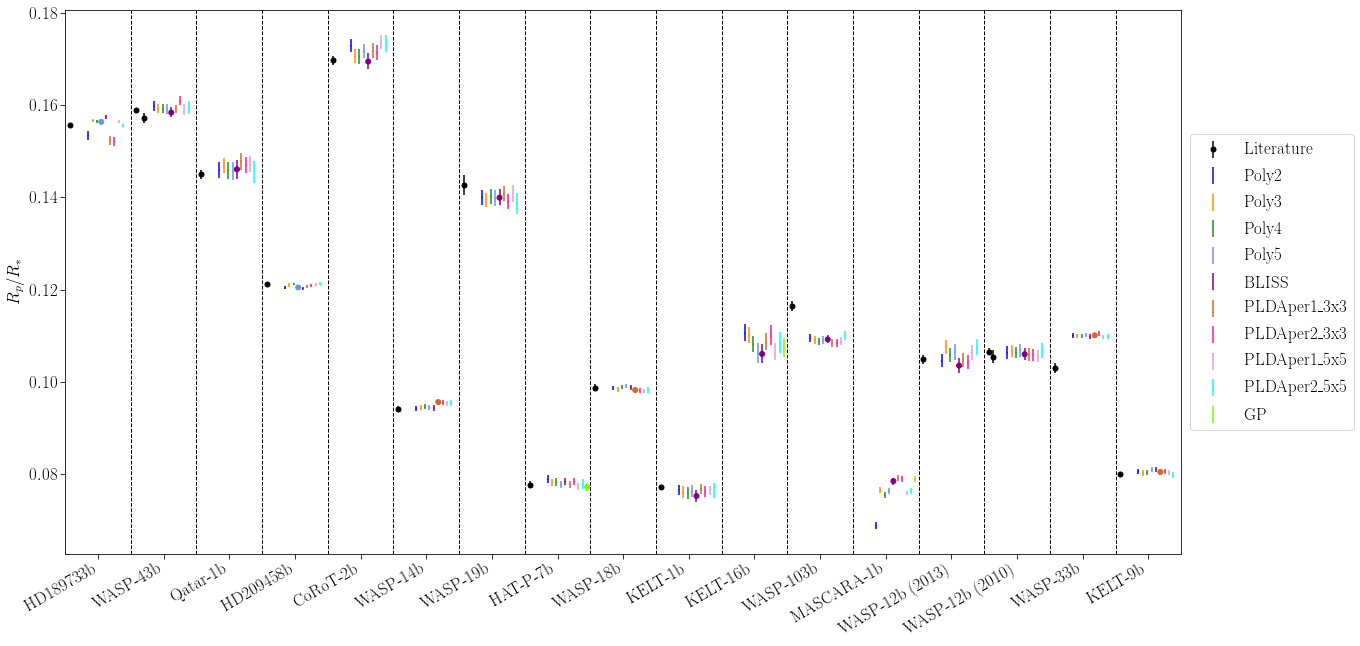

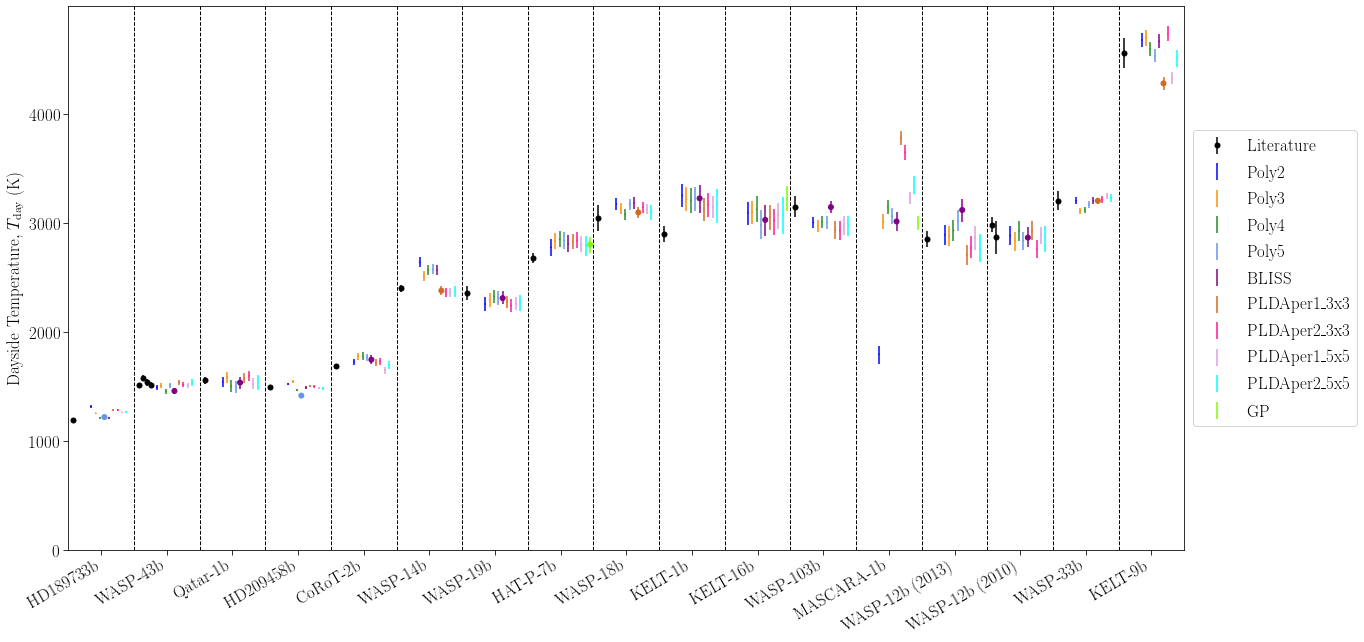

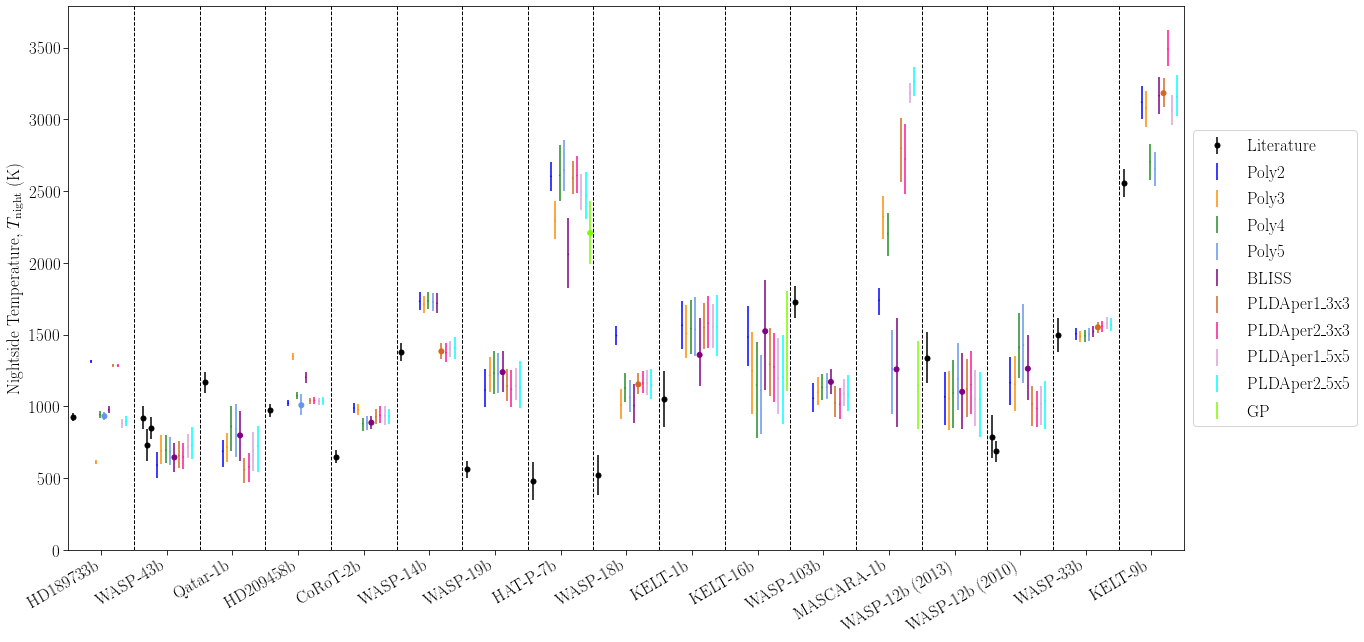

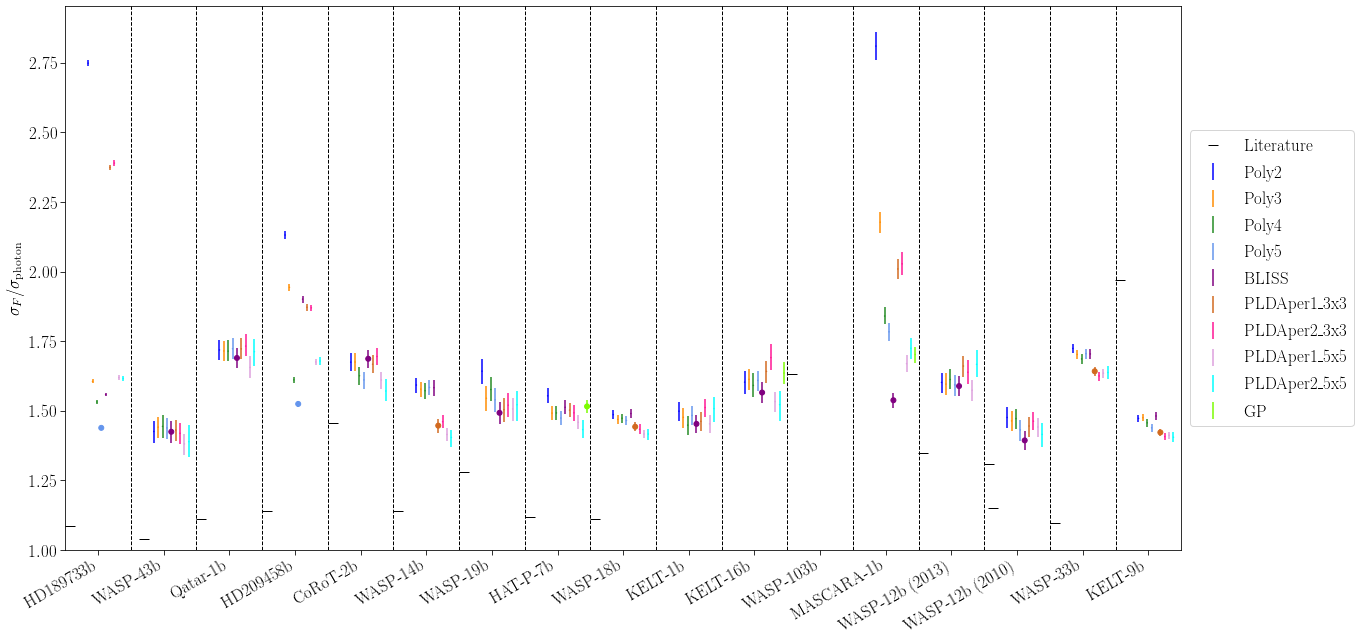

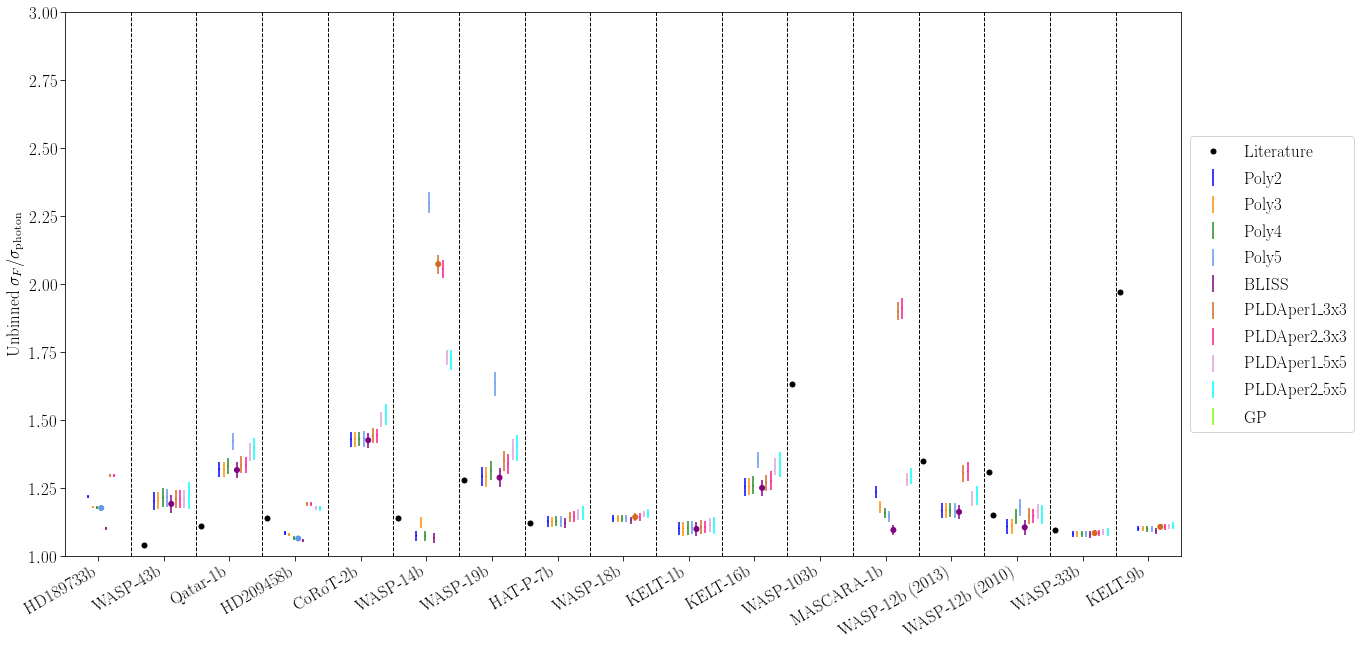

In [14]:
colors = ['blue', 'darkorange', 'forestgreen',
          'cornflowerblue', 'purple', 'chocolate',
          'deeppink', 'plum', 'cyan', 'lawngreen']

lit_order = [np.where(names_lit[i]==planets)[0][0] for i in range(len(names_lit))]
lit_x = np.arange(len(planets))[lit_order]-0.425
order = np.argsort(lit_x)
for i in [2,3,4,15]:
    lit_x[order[i]]+=0.06
for i in [3,4]:
    lit_x[order[i]]+=0.06
for i in [4]:
    lit_x[order[i]]+=0.06

    
xoffsets = np.linspace(0., 0.6, len(plotModes))
xoffsets += -np.median(xoffsets)+0.15
    
plt.figure(figsize=(20,10))
plt.errorbar(lit_x, amp_lit[:,0], yerr=amp_lit[:,1], fmt='.', ms=10, color='k', label=r'$\rm Literature$')
for i in range(len(planets)):
    plt.axvline(i+0.5, lw=1, ls='--', c='k')
for i in range(len(plotModes)):
    xoffset = xoffsets[i]
    ms = np.ones(T0s_MEGA[0][0].size)
    ms[modeBICs_MEGA[i]==np.nanmin(modeBICs_MEGA, axis=0)] *= 100
    plt.errorbar(np.arange(len(planets))+xoffset, fps_MEGA[i][0]*np.sqrt(As_MEGA[i][0]**2+Bs_MEGA[i][0]**2), yerr=fps_MEGA[i][0]*np.sqrt((As_MEGA[i][0]*As_MEGA[i][1:])**2+(Bs_MEGA[i][0]*Bs_MEGA[i][1:])**2)/np.sqrt(As_MEGA[i][0]**2+Bs_MEGA[i][0]**2), fmt='.', color=colors[i], ms=0, label=fancy_labels[i])
    plt.scatter(np.arange(len(planets))+xoffset, fps_MEGA[i][0]*np.sqrt(As_MEGA[i][0]**2+Bs_MEGA[i][0]**2), marker='.', color=colors[i], s=ms)
plt.xticks(np.arange(len(planets)), rotation=30)
plt.gca().set_xticklabels(fancy_planets, ha="right")
plt.ylabel(r'$\rm Phasecurve~Semi$-$\rm Amplitude~(ppm)$')
plt.xlim(-0.5,T0s_MEGA[0][0].size-0.5)
plt.ylim(0)
plt.legend(loc=6, bbox_to_anchor=(1,0.5))
plt.savefig('../MEGA/figures/amp.pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(20,10))
plt.errorbar(lit_x, offset_lit[:,0], yerr=offset_lit[:,1], fmt='.', ms=10, color='k', label=r'$\rm Literature$')
plt.plot([-0.75,T0s_MEGA[0][0].size-0.25], [0,0], '-', lw=0.5, c='k')
for i in range(len(planets)):
    plt.axvline(i+0.5, lw=1, ls='--', c='k')
for i in range(len(plotModes)):
    xoffset = xoffsets[i]
    ms = np.ones(T0s_MEGA[0][0].size)
    ms[modeBICs_MEGA[i]==np.nanmin(modeBICs_MEGA, axis=0)] *= 100
    plt.errorbar(np.arange(len(planets))+xoffset, offsets_MEGA[i][0], yerr=offsets_MEGA[i][1:], fmt='.', color=colors[i], ms=0, label=fancy_labels[i])
    plt.scatter(np.arange(len(planets))+xoffset, offsets_MEGA[i][0], marker='.', color=colors[i], s=ms)
plt.xticks(np.arange(len(planets)), rotation=30)
plt.gca().set_xticklabels(fancy_planets, ha="right")
plt.ylabel(r'$\rm Phasecurve~Offset~(^{\circ})$')
plt.xlim(-0.5,T0s_MEGA[0][0].size-0.5)
plt.ylim(-90,90)
plt.legend(loc=6, bbox_to_anchor=(1,0.5))
plt.savefig('../MEGA/figures/offset.pdf', bbox_inches='tight')
plt.savefig('/home/taylor/Downloads/offset.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(20,10))
plt.errorbar(lit_x, fp_lit[:,0], yerr=fp_lit[:,1], fmt='.', ms=10, color='k', label=r'$\rm Literature$')
for i in range(len(planets)):
    plt.axvline(i+0.5, lw=1, ls='--', c='k')
for i in range(len(plotModes)):
    xoffset = xoffsets[i]
    ms = np.ones(T0s_MEGA[0][0].size)
    ms[modeBICs_MEGA[i]==np.nanmin(modeBICs_MEGA, axis=0)] *= 100
    plt.errorbar(np.arange(len(planets))+xoffset, fps_MEGA[i][0], yerr=fps_MEGA[i][1:], fmt='.', color=colors[i], ms=0, label=fancy_labels[i])
    plt.scatter(np.arange(len(planets))+xoffset, fps_MEGA[i][0], marker='.', color=colors[i], s=ms)
plt.xticks(np.arange(len(planets)), rotation=30)
plt.gca().set_xticklabels(fancy_planets, ha="right")
plt.ylabel(r'$F_p/F_*~({\rm ppm})$')
plt.xlim(-0.5,T0s_MEGA[0][0].size-0.5)
plt.legend(loc=6, bbox_to_anchor=(1,0.5))
plt.savefig('../MEGA/figures/fday.pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(20,10))
plt.errorbar(lit_x, rp_lit[:,0], yerr=rp_lit[:,1], fmt='.', ms=10, color='k', label=r'$\rm Literature$')
for i in range(len(planets)):
    plt.axvline(i+0.5, lw=1, ls='--', c='k')
for i in range(len(plotModes)):
    xoffset = xoffsets[i]
    ms = np.ones(rps_MEGA[0][0].size)
    ms[modeBICs_MEGA[i]==np.nanmin(modeBICs_MEGA, axis=0)] *= 100
    plt.errorbar(np.arange(len(planets))+xoffset, rps_MEGA[i][0], yerr=rps_MEGA[i][1:], fmt='.', color=colors[i], ms=0, label=fancy_labels[i])
    plt.scatter(np.arange(len(planets))+xoffset, rps_MEGA[i][0], marker='.', color=colors[i], s=ms)
plt.xticks(np.arange(len(planets)), rotation=30)
plt.gca().set_xticklabels(fancy_planets, ha="right")
plt.ylabel(r'$R_p/R_*$')
plt.xlim(-0.5,T0s_MEGA[0][0].size-0.5)
plt.legend(loc=6, bbox_to_anchor=(1,0.5))
plt.savefig('../MEGA/figures/rp.pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(20,10))
plt.errorbar(lit_x, tday_lit[:,0], yerr=tday_lit[:,1], fmt='.', ms=10, color='k', label=r'$\rm Literature$')
for i in range(len(planets)):
    plt.axvline(i+0.5, lw=1, ls='--', c='k')
for i in range(len(plotModes)):
    xoffset = xoffsets[i]
    ms = np.ones(T0s_MEGA[0][0].size)
    ms[modeBICs_MEGA[i]==np.nanmin(modeBICs_MEGA, axis=0)] *= 100
    plt.errorbar(np.arange(len(planets))+xoffset, tDays_MEGA[i][0], yerr=tDays_MEGA[i][1:], fmt='.', color=colors[i], ms=0, label=fancy_labels[i])
    plt.scatter(np.arange(len(planets))+xoffset, tDays_MEGA[i][0], marker='.', color=colors[i], s=ms)
plt.xticks(np.arange(len(planets)), rotation=30)
plt.gca().set_xticklabels(fancy_planets, ha="right")
plt.ylabel(r'${\rm Dayside~Temperature,}~T_{\rm day} ~({\rm K})$')
plt.ylim(0)
plt.xlim(-0.5,T0s_MEGA[0][0].size-0.5)
plt.legend(loc=6, bbox_to_anchor=(1,0.5))
plt.savefig('../MEGA/figures/tday.pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(20,10))
plt.errorbar(lit_x, tnight_lit[:,0], yerr=tnight_lit[:,1], fmt='.', ms=10, color='k', label=r'$\rm Literature$')
for i in range(len(planets)):
    plt.axvline(i+0.5, lw=1, ls='--', c='k')
for i in range(len(plotModes)):
    xoffset = xoffsets[i]
    ms = np.ones(T0s_MEGA[0][0].size)
    ms[modeBICs_MEGA[i]==np.nanmin(modeBICs_MEGA, axis=0)] *= 100
    plt.errorbar(np.arange(len(planets))+xoffset, tNights_MEGA[i][0], yerr=tNights_MEGA[i][1:], fmt='.', color=colors[i], ms=0, label=fancy_labels[i])
    plt.scatter(np.arange(len(planets))+xoffset, tNights_MEGA[i][0], marker='.', color=colors[i], s=ms)
plt.xticks(np.arange(len(planets)), rotation=30)
plt.gca().set_xticklabels(fancy_planets, ha="right")
plt.ylabel(r'${\rm Nightside~Temperature,}~T_{\rm night} ~({\rm K})$')
plt.ylim(0)
plt.xlim(-0.5,T0s_MEGA[0][0].size-0.5)
plt.legend(loc=6, bbox_to_anchor=(1,0.5))
plt.savefig('../MEGA/figures/tnight.pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(lit_x, sigF_lit, '_', ms=10, color='k', label=r'$\rm Literature$')
for i in range(len(planets)):
    plt.axvline(i+0.5, lw=1, ls='--', c='k')
for i in range(len(plotModes)):
    xoffset = xoffsets[i]
    ms = np.ones(T0s_MEGA[0][0].size)
    ms[modeBICs_MEGA[i]==np.nanmin(modeBICs_MEGA, axis=0)] *= 100
    plt.errorbar(np.arange(len(planets))+xoffset, sigFs_MEGA[i][0]/sigF_photons_MEGA[i], yerr=sigFs_MEGA[i][1:]/sigF_photons_MEGA[i], fmt='.', color=colors[i], ms=0, label=fancy_labels[i])
    plt.scatter(np.arange(len(planets))+xoffset, sigFs_MEGA[i][0]/sigF_photons_MEGA[i], marker='.', color=colors[i], s=ms)
plt.xticks(np.arange(len(planets)), rotation=30)
plt.gca().set_xticklabels(fancy_planets, ha="right")
plt.ylabel(r'$\sigma_F/\sigma_{\rm photon}$')
plt.ylim(1)
plt.xlim(-0.5,T0s_MEGA[0][0].size-0.5)
plt.legend(loc=6, bbox_to_anchor=(1,0.5))
plt.savefig('../MEGA/figures/noise.pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(lit_x, sigF_lit_unBinned, '.', ms=10, color='k', label=r'$\rm Literature$')
for i in range(len(planets)):
    plt.axvline(i+0.5, lw=1, ls='--', c='k')
for i in range(len(plotModes)):
    xoffset = xoffsets[i]
    ms = np.ones(T0s_MEGA[0][0].size)
    ms[modeBICs_MEGA[i]==np.nanmin(modeBICs_MEGA, axis=0)] *= 100
    plt.errorbar(np.arange(len(planets))+xoffset, sigFs_unBinned_MEGA[i][0]/sigF_photons_unBinned_MEGA[i], yerr=sigFs_unBinned_MEGA[i][1:]/sigF_photons_unBinned_MEGA[i], fmt='.', color=colors[i], ms=0, label=fancy_labels[i])
    plt.scatter(np.arange(len(planets))+xoffset, sigFs_unBinned_MEGA[i][0]/sigF_photons_unBinned_MEGA[i], marker='.', color=colors[i], s=ms)
plt.xticks(np.arange(len(planets)), rotation=30)
plt.gca().set_xticklabels(fancy_planets, ha="right")
plt.ylabel(r'${\rm Unbinned}~\sigma_F/\sigma_{\rm photon}$')
plt.ylim(1, 3)
plt.xlim(-0.5,T0s_MEGA[0][0].size-0.5)
plt.legend(loc=6, bbox_to_anchor=(1,0.5))
plt.savefig('../MEGA/figures/unbinned_noise.pdf', bbox_inches='tight')
plt.show()

66.59764944224844
48.39608426180348
71.51489996626333
106.94046226283535
6.044024633571098
59.365229780359186
67.43537103359267
30.254446062910574
227.59698092423423
45.627795805889036


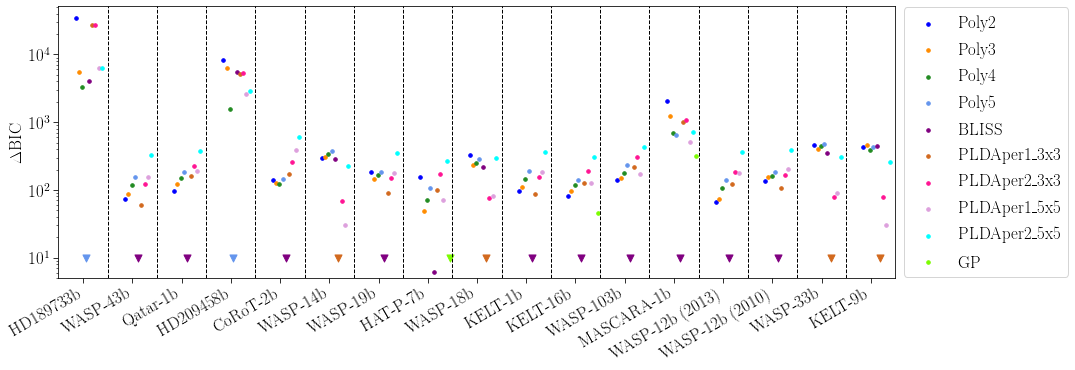

In [15]:
plt.figure(figsize=(15,15/3))
# plt.figure(figsize=(20,5))
for i in range(len(planets)):
    plt.axvline(i+0.5, lw=1, ls='--', c='k')
for i in range(len(plotModes)):
    xoffset = xoffsets[i]
    ms = np.ones(T0s_MEGA[0][0].size)
    ms[modeBICs_MEGA[i]==np.nanmin(modeBICs_MEGA, axis=0)] *= 100
    yPlot = modeBICs_MEGA[i]-np.nanmin(modeBICs_MEGA, axis=0)
    print(np.nanmin(yPlot[yPlot!=0]))
#     yPlot[yPlot==0] = 1
    plt.scatter(np.arange(len(planets))+xoffset, yPlot, marker='.', color=colors[i], s=50, label=fancy_labels[i])
    plt.scatter((np.arange(len(planets))+xoffset)[yPlot==0], 10*np.ones_like(yPlot[yPlot==0]), marker='v', color=colors[i], s=50)
plt.yscale('log')
plt.yticks([10,100,1000,10000])
# plt.gca().set_yticks((np.arange(1,10)*2*np.array([1,100,1e4])[:,np.newaxis]).flatten(), minor=True)
# plt.gca().set_yticklabels([], minor=True)
plt.ylim(5)
plt.xticks(np.arange(len(planets)), rotation=30)
plt.gca().set_xticklabels(fancy_planets, ha="right")
plt.ylabel(r'$\Delta{\rm BIC}$')
plt.xlim(-0.5,T0s_MEGA[0][0].size-0.5)
plt.legend(loc=6, bbox_to_anchor=(1,0.5))
plt.savefig('../MEGA/figures/BIC.pdf', bbox_inches='tight')
plt.show()

In [21]:
def setupBins(d):
    # Sigma clip
    sig0 = np.inf
    d_temp = np.copy(d)
    i=0
    while np.nanstd(d_temp)!=sig0:
        sig0 = np.nanstd(d_temp)
        d_temp = d_temp[np.abs(d_temp)<np.nanstd(d_temp)*3]
        i+=1
    width = sig0
    # Aim for an odd number of bins for the good models
    nBins = np.round((np.max(d_temp)-np.min(d_temp))/width)
    if nBins%2 != 1:
        nBins += 1
    width=(np.max(d_temp)-np.min(d_temp))/nBins
    # Setup bins
    bin_edges = np.arange(np.nanmin(d), np.nanmax(d)+width*0.999, width)
    centers = bin_edges[:-1] + width/2
    
    return width, bin_edges, centers

def plotbin(d, width, bin_edges, centers, colors, i):
    if np.all(np.isnan(d)):
        return
    else:
        total = d.size
        d = d[np.isfinite(d)]
    heights = np.histogram(d, bins=bin_edges)[0]
    heights = 0.8/total*heights    
    plt.barh(centers, heights, height=width, left=i, color=colors[i])
    
    return

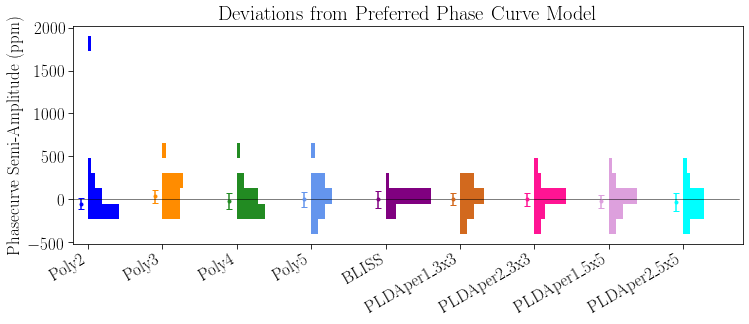

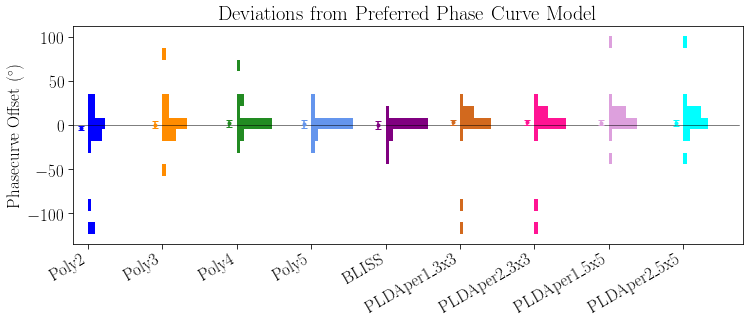

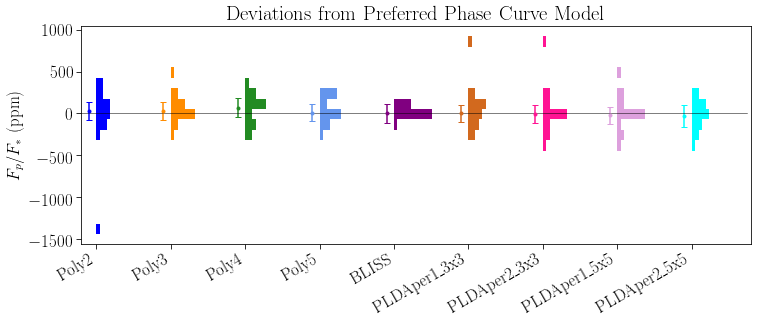

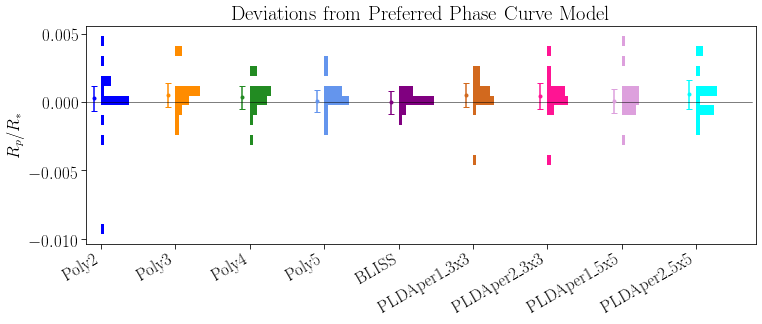

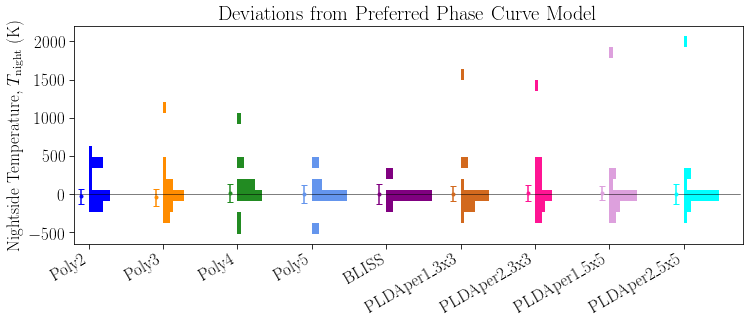

In [22]:
colors = ['blue', 'darkorange', 'forestgreen',
          'cornflowerblue', 'purple', 'chocolate',
          'deeppink', 'plum', 'cyan', 'lawngreen']


plt.figure(figsize=(12,4))
plt.title(r'$\rm Deviations~from~Preferred~Phase~Curve~Model$', fontsize=fontsize*1.2)
plt.plot([-0.75,len(plotModes)-0.25-1], [0,0], '-', lw=0.5, c='k')
amps = fps_MEGA*np.sqrt(As_MEGA**2+Bs_MEGA**2)
amp_errs = fps_MEGA[:,:1]/np.sqrt(As_MEGA[:,:1]**2+Bs_MEGA[:,:1]**2)*np.sqrt((As_MEGA[:,:1]*As_MEGA[:,1:])**2+(Bs_MEGA[:,:1]*Bs_MEGA[:,1:])**2)
d = amps[:,0]-amps[np.nanargmin(modeBICs_MEGA, axis=0),0,np.arange(len(planets))].T
width, bin_edges, centers = setupBins(d)
for i in range(len(plotModes)-1):
    d = amps[i,0]-amps[np.nanargmin(modeBICs_MEGA, axis=0),0,np.arange(len(planets))].T
    plotbin(d, width, bin_edges, centers, colors, i)
    plt.errorbar(i-0.1, np.nanmedian(amps[i,0]-amps[np.nanargmin(modeBICs_MEGA, axis=0),0,np.arange(len(planets))].T), yerr=np.nanmedian(amp_errs[i]), fmt='.', capsize=3, color=colors[i], label=fancy_labels[i])
plt.xticks(np.arange(len(plotModes)-1), rotation=30)
plt.gca().set_xticklabels(fancy_labels[:-1], ha="right")
plt.ylabel(r'$\rm Phasecurve~Semi$-$\rm Amplitude~(ppm)$')
plt.xlim(-0.2,len(plotModes)-0.2-1)
plt.savefig('../MEGA/figures/amp_diffs_bar_pref.pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(12,4))
plt.title(r'$\rm Deviations~from~Preferred~Phase~Curve~Model$', fontsize=fontsize*1.2)
plt.plot([-0.75,len(plotModes)-0.25-1], [0,0], '-', lw=0.5, c='k')
d = offsets_MEGA[:,0]-offsets_MEGA[np.nanargmin(modeBICs_MEGA, axis=0),0,np.arange(len(planets))].T
width, bin_edges, centers = setupBins(d)
for i in range(len(plotModes)-1):
    d = offsets_MEGA[i,0]-offsets_MEGA[np.nanargmin(modeBICs_MEGA, axis=0),0,np.arange(len(planets))].T
    plotbin(d, width, bin_edges, centers, colors, i)
    plt.errorbar(i-0.1, np.nanmedian(offsets_MEGA[i][0]-offsets_MEGA[np.nanargmin(modeBICs_MEGA, axis=0),0,np.arange(len(planets))].T), yerr=np.nanmedian(offsets_MEGA[i][1:]), fmt='.', capsize=3, color=colors[i], label=fancy_labels[i])
plt.xticks(np.arange(len(plotModes)-1), rotation=30)
plt.gca().set_xticklabels(fancy_labels[:-1], ha="right")
plt.ylabel(r'$\rm Phasecurve~Offset~(^{\circ})$')
plt.xlim(-0.2,len(plotModes)-0.2-1)
plt.savefig('../MEGA/figures/offset_diffs_bar_pref.pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(12,4))
plt.title(r'$\rm Deviations~from~Preferred~Phase~Curve~Model$', fontsize=fontsize*1.2)
plt.plot([-0.75,len(plotModes)-0.25-1], [0,0], '-', lw=0.5, c='k')
d = fps_MEGA[:,0]-fps_MEGA[np.nanargmin(modeBICs_MEGA, axis=0),0,np.arange(len(planets))].T
width, bin_edges, centers = setupBins(d)
for i in range(len(plotModes)-1):
    d = fps_MEGA[i,0]-fps_MEGA[np.nanargmin(modeBICs_MEGA, axis=0),0,np.arange(len(planets))].T
    plotbin(d, width, bin_edges, centers, colors, i)
    
    plt.errorbar(i-0.1, np.nanmedian(fps_MEGA[i,0]-fps_MEGA[np.nanargmin(modeBICs_MEGA, axis=0),0,np.arange(len(planets))].T), yerr=np.nanmedian(fps_MEGA[i][1:]), fmt='.', capsize=3, color=colors[i], label=fancy_labels[i])
plt.xticks(np.arange(len(plotModes)-1), rotation=30)
plt.gca().set_xticklabels(fancy_labels[:-1], ha="right")
plt.ylabel(r'$F_p/F_*~({\rm ppm})$')
plt.xlim(-0.2,len(plotModes)-0.2-1)
plt.savefig('../MEGA/figures/fday_diffs_bar_pref.pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(12,4))
plt.title(r'$\rm Deviations~from~Preferred~Phase~Curve~Model$', fontsize=fontsize*1.2)
plt.plot([-0.75,len(plotModes)-0.25-1], [0,0], '-', lw=0.5, c='k')
d = rps_MEGA[:,0]-rps_MEGA[np.nanargmin(modeBICs_MEGA, axis=0),0,np.arange(len(planets))].T
width, bin_edges, centers = setupBins(d)
for i in range(len(plotModes)-1):
    d = rps_MEGA[i,0]-rps_MEGA[np.nanargmin(modeBICs_MEGA, axis=0),0,np.arange(len(planets))].T
    plotbin(d, width, bin_edges, centers, colors, i)
    plt.errorbar(i-0.1, np.nanmedian(rps_MEGA[i,0]-rps_MEGA[np.nanargmin(modeBICs_MEGA, axis=0),0,np.arange(len(planets))].T), yerr=np.nanmedian(rps_MEGA[i][1:]), fmt='.', capsize=3, color=colors[i], label=fancy_labels[i])
plt.xticks(np.arange(len(plotModes)-1), rotation=30)
plt.gca().set_xticklabels(fancy_labels[:-1], ha="right")
plt.ylabel(r'$R_p/R_*$')
plt.xlim(-0.2,len(plotModes)-0.2-1)
plt.savefig('../MEGA/figures/rp_diffs_bar_pref.pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(12,4))
plt.title(r'$\rm Deviations~from~Preferred~Phase~Curve~Model$', fontsize=fontsize*1.2)
plt.plot([-0.75,len(plotModes)-0.25-1], [0,0], '-', lw=0.5, c='k')
d = tNights_MEGA[:,0]-tNights_MEGA[np.nanargmin(modeBICs_MEGA, axis=0),0,np.arange(len(planets))].T
width, bin_edges, centers = setupBins(d)
for i in range(len(plotModes)-1):
    d = tNights_MEGA[i,0]-tNights_MEGA[np.nanargmin(modeBICs_MEGA, axis=0),0,np.arange(len(planets))].T
    plotbin(d, width, bin_edges, centers, colors, i)
#     plt.errorbar(i, np.nanmedian(tNights_MEGA[i,0]-tNights_MEGA[np.nanargmin(modeBICs_MEGA, axis=0),0,np.arange(len(planets))].T), yerr=np.nanstd(tNights_MEGA[i,0]-np.nanmedian(tNights_MEGA[:,0], axis=0)), fmt='.', capsize=3, color=colors[i], ms=10, label=fancy_labels[i])
    plt.errorbar(i-0.1, np.nanmedian(tNights_MEGA[i,0]-tNights_MEGA[np.nanargmin(modeBICs_MEGA, axis=0),0,np.arange(len(planets))].T), yerr=np.nanmedian(tNights_MEGA[i][1:]), fmt='.', capsize=3, color=colors[i], label=fancy_labels[i])
plt.xticks(np.arange(len(plotModes)-1), rotation=30)
plt.gca().set_xticklabels(fancy_labels[:-1], ha="right")
plt.ylabel(r'${\rm Nightside~Temperature,}~T_{\rm night} ~({\rm K})$')
plt.xlim(-0.2,len(plotModes)-0.2-1)
plt.savefig('../MEGA/figures/tnight_diffs_bar_pref.pdf', bbox_inches='tight')
plt.show()

In [23]:
T0 = np.array([T0s_MEGA[np.nanargmin(modeBICs_MEGA[:,i]),:,i] if not np.all(np.isnan(modeBICs_MEGA[:,i])) else [np.nan,np.nan] for i in range(len(planets))])
Td = np.array([tDays_MEGA[np.nanargmin(modeBICs_MEGA[:,i]),:,i] if not np.all(np.isnan(modeBICs_MEGA[:,i])) else [np.nan,np.nan,np.nan] for i in range(len(planets))])
Tn = np.array([tNights_MEGA[np.nanargmin(modeBICs_MEGA[:,i]),:,i] if not np.all(np.isnan(modeBICs_MEGA[:,i])) else [np.nan,np.nan,np.nan] for i in range(len(planets))])
offset = np.array([offsets_MEGA[np.nanargmin(modeBICs_MEGA[:,i]),:,i] if not np.all(np.isnan(modeBICs_MEGA[:,i])) else [np.nan,np.nan,np.nan] for i in range(len(planets))])
planets_temp = planets

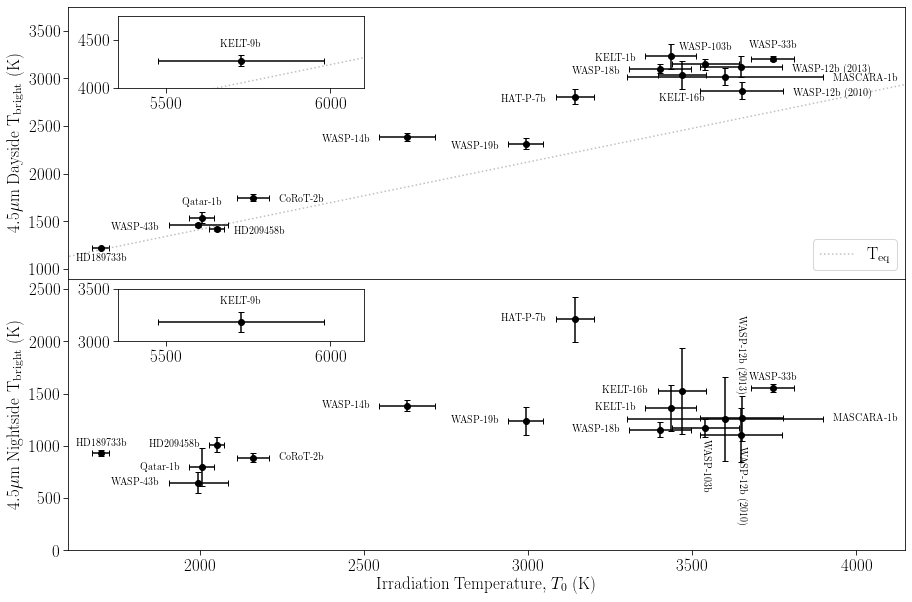

In [24]:
fig, ax = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0}, figsize=(15,10))

ax[0].errorbar(T0[:,0], Td[:,0], xerr=T0[:,1], yerr=Td[:,1], fmt='o', color='k', capsize=3)
ax[0].plot([1000,4500], np.array([1000,4500])*0.25**0.25, c='grey', ls='dotted', alpha=0.5, label=r'$\rm T_{eq}$')
left=[1,5,6,7,8,9]
top=[2,11,15]
bottom=[0,10]
rotright=[]
rotrightup = []
for i in range(len(planets_temp)-1):
    if i in left:
        ax[0].text(T0[i,0]-T0[i,1]-30, Td[i,0]-30, fancy_planets[i], ha='right', va='center')
    elif i in top:
        ax[0].text(T0[i,0], Td[i,0]+Td[i,1]+60, fancy_planets[i], ha='center', va='bottom')
    elif i in bottom:
        ax[0].text(T0[i,0], Td[i,0]-Td[i,1]-60, fancy_planets[i], ha='center', va='top')
    elif i in rotright:
        ax[0].text(T0[i,0], Td[i,0]-Td[i,1]-60, fancy_planets[i], ha='center', va='top', rotation=-90)    
    elif i in rotrightup:
        ax[0].text(T0[i,0], Td[i,0]+Td[i,1]+60, fancy_planets[i], ha='center', va='bottom', rotation=-90)  
    else:
        ax[0].text(T0[i,0]+T0[i,1]+30, Td[i,0]-30, fancy_planets[i], ha='left', va='center')
ax[0].set_xlim(1600,4150)
ax[0].set_ylim(900,3750)
ax[0].set_ylabel(r'$\rm 4.5\mu m~Dayside~T_{bright}~(K)$')
ax[0].set_xlabel(r'${\rm Irradiation~Temperature,}~T_{\rm 0} ~({\rm K})$')
ax[0].legend(loc=4)
axin1 = ax[0].inset_axes([1750, 2900, 750, 750], transform=ax[0].transData)
axin1.errorbar(T0[:,0][-1], Td[:,0][-1], xerr=T0[:,1][-1], yerr=Td[:,1][-1], fmt='o', color='k', capsize=3)
axin1.text(T0[-1,0], Td[-1,0]+Td[-1,1]+60, fancy_planets[-1], ha='center', va='bottom')
axin1.plot([1000,6500], np.array([1000,6500])*0.25**0.25, c='grey', ls='dotted', alpha=0.5)
axin1.set_xlim(T0[-1,0]-750/2,T0[-1,0]+750/2)
axin1.set_xticks([5500,6000])
axin1.set_ylim(4000,4750)

ax[1].errorbar(T0[:,0], Tn[:,0], xerr=T0[:,1], yerr=Tn[:,1], fmt='o', color='k', capsize=3)
left=[1,2,3,5,6,7,8,9,10]
top=[0,15]
bottom=[]
rotright=[11,14]
rotrightup = [13]
for i in range(len(planets_temp)-1):
    if i in left:
        ax[1].text(T0[i,0]-T0[i,1]-30, Tn[i,0]+0, fancy_planets[i], ha='right', va='center')
    elif i in top:
        ax[1].text(T0[i,0], Tn[i,0]+Tn[i,1]*1.5, fancy_planets[i], ha='center', va='bottom')
    elif i in bottom:
        ax[1].text(T0[i,0], Tn[i,0]-Tn[i,1]*1.5, fancy_planets[i], ha='center', va='top')
    elif i in rotright:
        ax[1].text(T0[i,0], Tn[i,0]-Tn[i,1]*1.25, fancy_planets[i], ha='center', va='top', rotation=-90)    
    elif i in rotrightup:
        ax[1].text(T0[i,0], Tn[i,0]+Tn[i,1]*1.5, fancy_planets[i], ha='center', va='bottom', rotation=-90) 
    else:
        ax[1].text(T0[i,0]+T0[i,1]+30, Tn[i,0]+0, fancy_planets[i], ha='left', va='center')
ax[1].set_ylim(0,2600)
ax[1].set_ylabel(r'$\rm 4.5\mu m~Nightside~T_{bright}~(K)$')
ax[1].set_xlabel(r'${\rm Irradiation~Temperature,}~T_{\rm 0} ~({\rm K})$')
axin2 = ax[1].inset_axes([1750, 2000, 750, 500], transform=ax[1].transData)
axin2.errorbar(T0[:,0][-1], Tn[:,0][-1], xerr=T0[:,1][-1], yerr=Tn[:,1][-1], fmt='o', color='k', capsize=3)
axin2.text(T0[-1,0], Tn[-1,0]+Tn[-1,1]*1.5, fancy_planets[-1], ha='center', va='bottom')
axin2.set_xlim(T0[-1,0]-750/2,T0[-1,0]+750/2)
axin2.set_xticks([5500,6000])
axin2.set_ylim(3000,3500)

plt.savefig('../MEGA/figures/Tb_T0.pdf', bbox_inches='tight')
plt.savefig('/home/taylor/Downloads/Tb_T0.png', dpi=300, bbox_inches='tight')


plt.show()

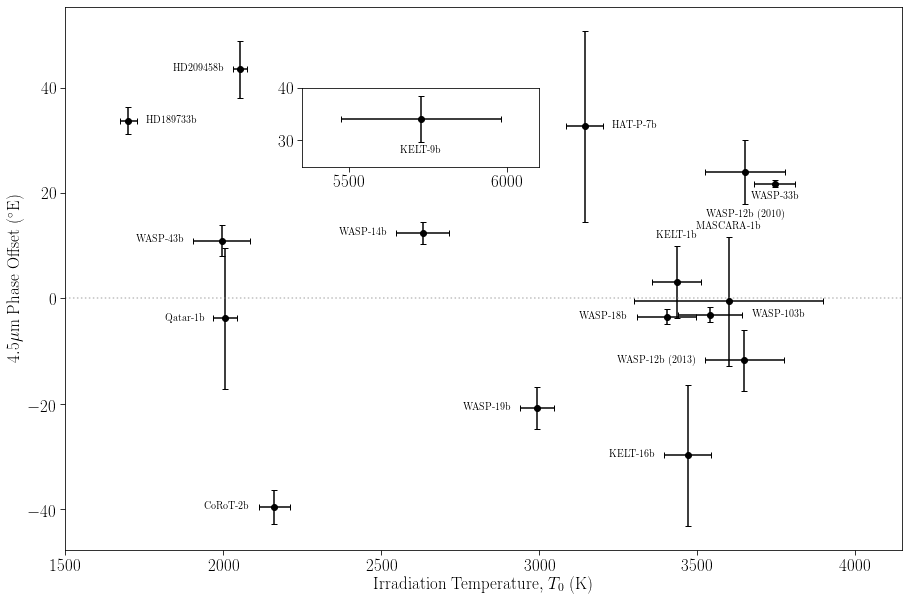

In [25]:
plt.figure(figsize=(15,10))
plt.errorbar(T0[:,0], offset[:,0], xerr=T0[:,1], yerr=offset[:,1], fmt='o', color='k', capsize=3)
left=[1,2,3,4,5,6,8,10,13]
bottom=[8,14,15]
top=[9,12]
rotright=[8]
rotrightup=[]
for i in range(len(planets_temp)-1):
    if i in left:
        plt.text(T0[i,0]-T0[i,1]-30, offset[i,0]+0, fancy_planets[i], ha='right', va='center')
    elif i in top:
        plt.text(T0[i,0], offset[i,0]+offset[i,1]+1, fancy_planets[i], ha='center', va='bottom')
    elif i in bottom:
        plt.text(T0[i,0], offset[i,0]-offset[i,1]-1, fancy_planets[i], ha='center', va='top')
    elif i in rotright:
        plt.text(T0[i,0], offset[i,0]-offset[i,1]-1, fancy_planets[i], ha='center', va='top', rotation=-90)    
    elif i in rotrightup:
        plt.text(T0[i,0], offset[i,0]+offset[i,1]+1, fancy_planets[i], ha='center', va='bottom', rotation=-90) 
    else:
        plt.text(T0[i,0]+T0[i,1]+30, offset[i,0]+0, fancy_planets[i], ha='left', va='center')

plt.plot([1500,4150],[0,0],c='grey',ls='dotted',alpha=0.5)
plt.xlim(1500,4150)

ax = plt.gca()
axin1 = ax.inset_axes([2250, 25, 750, 15], transform=ax.transData)
axin1.errorbar(T0[:,0][-1], offset[:,0][-1], xerr=T0[:,1][-1], yerr=offset[:,1][-1], fmt='o', color='k', capsize=3)
axin1.text(T0[-1,0], offset[-1,0]-offset[-1,1]-1, fancy_planets[-1], ha='center', va='top')
axin1.set_xlim(T0[-1,0]-750/2,T0[-1,0]+750/2)
axin1.set_xticks([5500,6000])
axin1.set_ylim(25,40)


plt.ylabel(r'$\rm 4.5\mu m~Phase~Offset~(^{\circ}E)$')
plt.xlabel(r'${\rm Irradiation~Temperature,}~T_{\rm 0} ~({\rm K})$')

plt.savefig('../MEGA/figures/offset_T0.pdf', bbox_inches='tight')
plt.savefig('/home/taylor/Downloads/offset_T0.png', dpi=300, bbox_inches='tight')
plt.show()

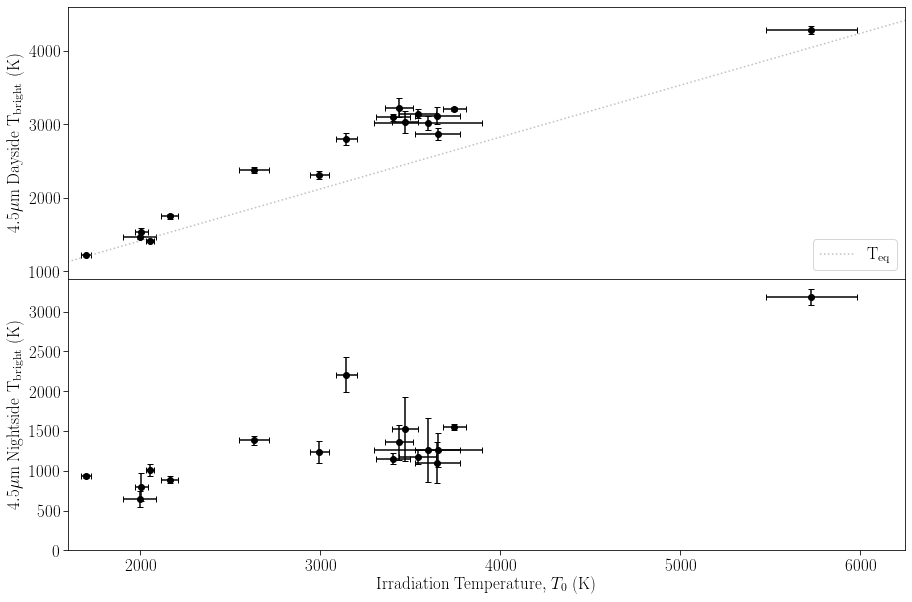

In [34]:
fig, ax = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0}, figsize=(15,10))

ax[0].errorbar(T0[:,0], Td[:,0], xerr=T0[:,1], yerr=Td[:,1], fmt='o', color='k', capsize=3)
ax[0].plot([1000,6250], np.array([1000,6250])*0.25**0.25, c='grey', ls='dotted', alpha=0.5, label=r'$\rm T_{eq}$')
# left=[1,5,6,7,8,9]
# top=[2,11,15]
# bottom=[0,10,16]
# rotright=[]
# rotrightup = []
# for i in range(len(planets_temp)):
#     if i in left:
#         ax[0].text(T0[i,0]-T0[i,1]-30, Td[i,0]-30, fancy_planets[i], ha='right', va='center')
#     elif i in top:
#         ax[0].text(T0[i,0], Td[i,0]+Td[i,1]+60, fancy_planets[i], ha='center', va='bottom')
#     elif i in bottom:
#         ax[0].text(T0[i,0], Td[i,0]-Td[i,1]-60, fancy_planets[i], ha='center', va='top')
#     elif i in rotright:
#         ax[0].text(T0[i,0], Td[i,0]-Td[i,1]-60, fancy_planets[i], ha='center', va='top', rotation=-90)    
#     elif i in rotrightup:
#         ax[0].text(T0[i,0], Td[i,0]+Td[i,1]+60, fancy_planets[i], ha='center', va='bottom', rotation=-90)  
#     else:
#         ax[0].text(T0[i,0]+T0[i,1]+30, Td[i,0]-30, fancy_planets[i], ha='left', va='center')
ax[0].set_xlim(1600,6250)
ax[0].set_ylim(900)
ax[0].set_ylabel(r'$\rm 4.5\mu m~Dayside~T_{bright}~(K)$')
ax[0].set_xlabel(r'${\rm Irradiation~Temperature,}~T_{\rm 0} ~({\rm K})$')
ax[0].legend(loc=4)

ax[1].errorbar(T0[:,0], Tn[:,0], xerr=T0[:,1], yerr=Tn[:,1], fmt='o', color='k', capsize=3)
left=[1,2,3,5,6,7,8,9,10]
top=[0,15]
bottom=[16]
rotright=[11,14]
rotrightup = [13]
# for i in range(len(planets_temp)):
#     if i in left:
#         ax[1].text(T0[i,0]-T0[i,1]-30, Tn[i,0]+0, fancy_planets[i], ha='right', va='center')
#     elif i in top:
#         ax[1].text(T0[i,0], Tn[i,0]+Tn[i,1]*1.5, fancy_planets[i], ha='center', va='bottom')
#     elif i in bottom:
#         ax[1].text(T0[i,0], Tn[i,0]-Tn[i,1]*1.5, fancy_planets[i], ha='center', va='top')
#     elif i in rotright:
#         ax[1].text(T0[i,0], Tn[i,0]-Tn[i,1]*1.25, fancy_planets[i], ha='center', va='top', rotation=-90)    
#     elif i in rotrightup:
#         ax[1].text(T0[i,0], Tn[i,0]+Tn[i,1]*1.5, fancy_planets[i], ha='center', va='bottom', rotation=-90) 
#     else:
#         ax[1].text(T0[i,0]+T0[i,1]+30, Tn[i,0]+0, fancy_planets[i], ha='left', va='center')
ax[1].set_ylim(0)
ax[1].set_ylabel(r'$\rm 4.5\mu m~Nightside~T_{bright}~(K)$')
ax[1].set_xlabel(r'${\rm Irradiation~Temperature,}~T_{\rm 0} ~({\rm K})$')

plt.savefig('/home/taylor/Downloads/Tb_T0.png', dpi=300, bbox_inches='tight')


plt.show()

In [26]:
import shutil

In [27]:
folders_best = np.array([folders_MEGA[np.nanargmin(modeBICs_MEGA[:,i]),i] if not np.all(np.isnan(modeBICs_MEGA[:,i])) else ['None'] for i in range(len(planets))])
bestfit_plots = [[folders_best[i]+'/'+file for file in os.listdir(folders_best[i]) if 'Bestfit_' in file][0] for i in range(len(folders_best))]

In [28]:
for i in range(len(planets)):
    shutil.copyfile(bestfit_plots[i], f"../MEGA/figures/pcs/{planets[i]}_{bestfit_plots[i].split('/')[-1]}")